Wczytamy dane z pliku *zad1.csv*, format danych w pliku został zmodyfikowany, żeby łatwiej było się nim posługiwać.

In [1]:
import pandas
data_frame = pandas.read_csv("zad1.csv")
data_frame

,A,B,C
0,246,243,265
1,231,246,260
2,236,243,265
3,217,235,253
4,246,235,291


Przeprowadzimy analizę wariancji (ANOVA), w celu ustalenia czy **średnia liczba ogłoszeń w trzech gazetach jest taka sama**. Inaczej:

$$
H_0 : x_{A\bullet} = x_{B\bullet} = x_{C\bullet}
$$

$$
H_a : \exists_{x _{i\bullet}, x_{j\bullet}, i \neq j}\  x_{i\bullet}\neq x_{j\bullet}
$$

Wartości potrzebne do przeprowadzenia analizy można zaprezentować w postaci tabelki

| df         |  SS        | MS         | f                      |         |
| ---------- | ---------- | ---------- | ---------------------- | ------- | 
| $I - 1$    | $SSA$      | $MSA$      | $\frac{MSA}{MSE}$      | p-value |
| $I(J - 1)$ | $SSE$      | $MSE$      |                        |         |

gdzie $I$ oznacza liczbę grup, a $J$ obserwacji na grupę. Pierwszą i drugą kolumnę liczymy na podstawie danych, a każde kolejne na podstawie poprzednich.

Korzystając ze wzorów z wykładu, na początku ustalimy wartość zmienności międzygrupowej $SSA$

$$
    SSA = \sum_{i = 1}^I \sum_{j = 1}^J \ (x_{i\bullet} - \bar{x})^2 = 
    J \sum_{i = 1}^I (x_{i\bullet} - \bar{x})^2,
$$

gdzie 

$$
    x_{i\bullet} = \frac{1}{J} \sum_{j=1}^J x_{ij},
$$

$\bar{x}$ średnią wszystkich obserwacji, czyli

$$
    \bar{x} = \frac{1}{IJ} \sum_{i,j} x_{ij}.
$$

Najpierw policzymy wartości potrzebnych średnich $x_{i\bullet}$ i $\bar{x}$

In [2]:
import numpy

newspapers = data_frame.columns;
means = data_frame.mean()

global_header = "global"

means[global_header] = numpy.mean(means)
print(means)

A         235.200000
B         240.400000
C         266.800000
global    247.466667
dtype: float64


Po czym możemy przejść do wyznaczenia $SSA$

In [3]:
ssa = 0
for newspaper in newspapers:
    ssa += (means[newspaper] - means[global_header])**2
ssa *= len(data_frame)

print('SSA = ', ssa)

SSA =  2870.9333333333366


Z wykładu wiemy że z dokładnością do stałej

$$
    SSA \sim \chi^2(I - 1)
$$

Teraz możemy przejść do wyznaczenia zmienności wewnątrzgrupowej $SSE$

$$
    SSE = \sum_{i,j} (x_{ij} - x_{i\bullet})^2
$$

In [4]:
sse = 0
for newspaper in newspapers:
    for x in data_frame[newspaper]:
        sse += (x - means[newspaper])**2
print("SSE = ", sse)

SSE =  1514.7999999999997


Z wykładu wiemy, że

$$
    SSE \sim \chi^2(J(I - 1))
$$


Następnie możemy przejść do wyznaczenia $MSA$ i $MSE$

$$
MSA = \frac{SSA}{I - 1}
$$

$$
MSE = \frac{SSE}{I(J - 1)},
$$

czyli odpowiednio $SSA$ i $SSE$ podzielone przez ich stopnie swobody.

In [5]:
deg_of_freedom_ssa = len(data_frame.columns) - 1
deg_of_freedom_sse = len(data_frame.columns) * (len(data_frame) - 1)

msa = ssa / deg_of_freedom_ssa
mse = sse / deg_of_freedom_sse

print("MSA = ", msa)
print("MSE = ", mse)

MSA =  1435.4666666666683
MSE =  126.2333333333333


Kolejnym krokiem jest wyznaczenia wartości $F$

$$
    f = \frac{MSA}{MSE},
$$

a stąd, że

$$
    MSA \sim \frac{\chi^2(I - 1)}{I - 1}
$$
i
$$
    MSE \sim \frac{ \chi^2(I(J - 1)) }{I(J-1)}
$$

wnioskujemy następujące (przy założeniu że $H_0$ jest prawdziwe)

$$
    f = \frac{MSA}{MSE} \sim F(J - 1, I(J-1)),
$$

bo rozkład Fishera-Snedecore'a może być przedstawiony jako stosunek przeskalowanych rozkładów $\chi^2$.

In [6]:
f = msa / mse
print("f = ", f)

f =  11.371534195933473


Znając wartość zmiennej losowej $F$ oraz jej rozkład możemy policzyć $p\_value$, czyli szanse że zdarzyło się coś mniej prawdopodobnego. Rozkład $F(2,12)$ w przypadku tych parametrów nie ma "grzbietu".

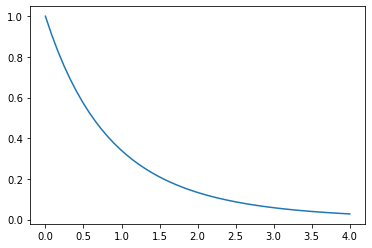

In [7]:
from matplotlib import pyplot
from scipy import stats

linspc = numpy.linspace(0,4)

pyplot.plot(linspc, list(map( lambda x: stats.f.pdf(x,2,12), linspc) ) )
pyplot.show()

Dlatego $p\_value$ możemy określić obliczając 

$$
 p\_value = 1 - P(F < f),
$$

czyli wartość tzw. *funkcji przeżycia* (ang. *survival function*).

In [8]:
p_value = stats.f.sf(f, deg_of_freedom_ssa, deg_of_freedom_sse)
print("p_value = ", p_value)

p_value =  0.0016977684112495733


Decyzja o odrzuceniu hipotezy zerowej jest teraz zależna od ustalonego $\alpha$, z którego wynika pole obszaru krytycznego. (chociaż jeśli jest to jakakolwiek sensowna wartość to zapewne zostanie odrzucona)